#T-SNE and Kullback-Leibler divergence

This notebook contains the code for a recent blog post I wrote about the use of t-distributed stochastic neighbor embedding and its connection to the Kullback-Leibler divergence. T-SNE can be used to visualize and cluster high-dimensional datasets to make them accessible and gain intuition about the sparisity and distribution

# Kullback-Leibler divergence

The [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is a well known quantity in information studiesa nd statistics. It is used to measure the differences between two probability distributions $P$ and $Q$, where $P$ is called the "true" distribution and $Q$ its model or approximation. The KL divergence is defined as

$$
\begin{align}
\text{KL}(P||Q) = & \sum_i P_i \log \left( \frac{P_i}{Q_i} \right) \\
 = & \sum_i P_i \log \left( P_i \right) - \sum_i P_i \log \left( Q_i \right) \\
 = & - H(P) + H(P, Q) 
\end{align}
$$

where $H(P)$ and $H(P,Q)$ are the self-entropy and mutual information measures of the probability distributions.

Some properties:
- $\text{KL}(P||Q) \geq 0$: Easy to see when using first order Taylor expansion $\ln x \leq x-1$
- If $P = P_1 \cdot P_2$ with two independent distributions $P_1$, $P_2$, then $\text{KL}(P||Q) = \text{KL}(P_1||Q_1) + \text{KL}(P_2||Q_2)$, where $Q_1$, $Q_2$ are the respective models of $P_1$ and $P_2$
- $\text{KL}(P||Q)$ is **not** a metric, as it violates the triangle inequality $||x + y || \leq ||x|| + ||y||$ and is not symmeric, i.e. $\text{KL}(P||Q) \neq \text{KL}(Q||P)$

##Simulation of the Kullback-Leibler divergence

Let's have a look at our most favorite theorem - the central limit theorem. An example of it is given by $n$-identically distributed Bernoulli variables. If $Y_i \sim \text{Bern} (p)$, $i\in \{1,..., n\}$ then their sum approaches a Normal distribution 

$$
\begin{equation}
Y = \sum_{i=1}^n Y_i \rightarrow \mathcal{N} \big(np, np(1-p)\big)
\end{equation}
$$

We can now use the KL divergence to quantify how far away from a normal distribution we are. In this case $\mathcal{N} \big(np, np(1-p)\big)$ is our model and the distribution of $Y$ is generated numerically

###Preparations and code

In [85]:
import pymc
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
def calculate_single_kl_value(p, q):
    return p * (np.log(p) - np.log(q))

def single_bernoulli_draw(p, n_bern):
    bernoulli = pymc.Bernoulli('bern', p, size = n_bern)
    return float(bernoulli.value.sum())

def perform_bernoulli_experiment(p, n_bern, n_samples):
    bernoulli_successes = []
    for idx in range(n_samples):
        bernoulli_successes.append(single_bernoulli_draw(p, n_bern))
    return bernoulli_successes

def calculate_full_kullback_leibler(p, n_samples, n_bern):
    bernoulli_successes = perform_bernoulli_experiment(p, n_bern, n_samples)

    bern_hist, bern_loc = np.histogram(bernoulli_successes, bins=100, density=True)
    
    mu = p * n_bern
    sigma = mu * (1 - p)

    kl = 0 
    null_cnt = 0
    for idx in range(len(bern_loc)-1):
        x = bern_loc[idx]
        p = bern_hist[idx]
        q = stats.norm.pdf(x, loc=mu, scale=sigma)
        if (p > 0.0) & (q > 0.0):
            kl += calculate_single_kl_value(p, q)
        else:
            null_cnt += 1

    return kl / (n_samples - null_cnt)

###Histogram of the Bernoulli variable

... looks pretty normal, I would say

0.00884955752212 0.0107956438107


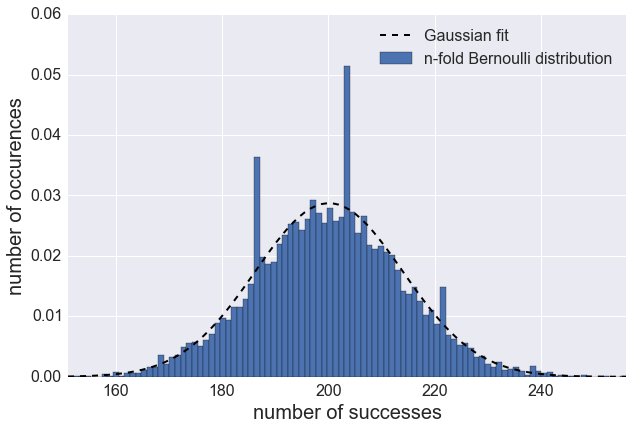

In [49]:
from scipy.stats import norm

fig = plt.figure(figsize=(10, 6.5))
data = perform_bernoulli_experiment(0.02, 10000, 10000)
hist = plt.hist(data , bins=99, normed= True, label = 'n-fold Bernoulli distribution');
plt.xlabel('number of successes', fontsize = 20);
plt.ylabel('number of occurences', fontsize = 20);
plt.tick_params(axis='both', which='major', labelsize=16);
plt.tick_params(axis='both', which='minor', labelsize=12);

mu, std = norm.fit(data)

x = np.linspace(min(data), max(data), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--k', linewidth=2, label='Gaussian fit')

plt.xlim([min(data), max(data)])
plt.legend(loc='best', fontsize=16)

###KL curve with uncertainty and mean

In [9]:
p = 0.02
n_bern = 10000
sample_sizes = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 50000]


lst_kl_values = []
for idx in range(10):
    kl_values = []
    for n_samples in sample_sizes:
        kl_values.append(calculate_full_kullback_leibler(p, n_samples, n_bern))
    lst_kl_values.append(kl_values)
kl_array = np.asarray(lst_kl_values)

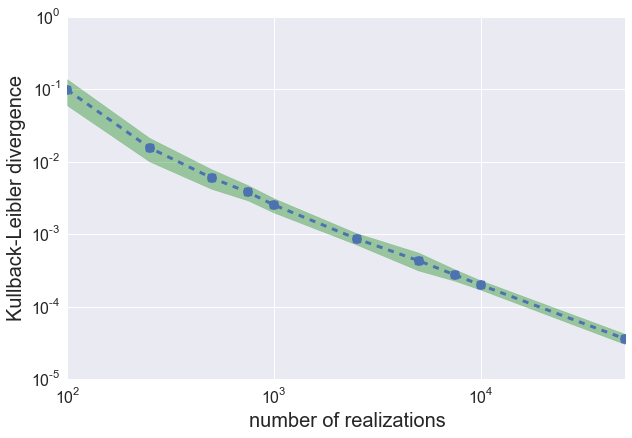

In [82]:
fig = plt.figure(figsize=(10, 6.5))
p1 = plt.loglog(sample_sizes, kl_array.mean(axis=0), '--o', markersize=10, linewidth = 3, label = 'mean');

p2 = plt.fill_between(sample_sizes,
                 kl_array.mean(axis=0) + 3* kl_array.std(axis=0),
                 kl_array.mean(axis=0) - 3* kl_array.std(axis=0),
                 color='green',
                 alpha='0.35',
                 label= 'sigma range')
plt.xlabel('number of realizations', fontsize = 20);
plt.ylabel('Kullback-Leibler divergence', fontsize = 20);
plt.xlim([min(sample_sizes), max(sample_sizes)])
plt.tick_params(axis='both', which='major', labelsize=16);
plt.tick_params(axis='both', which='minor', labelsize=12);

The Kullback-Leibler divergence quickly approaches zero and with as few as 1000 samples we're already well below $10^{-2}$ in difference to a Normal distribution. Long live the central limit theorem!

# Stochastic neighbor embedding

We can leverage the property of the KL divergency to do effective visualization of high dimensional datasets. The key trick is to realize that we can convert distances into probabilities in the high-dimensional embedding space and the low-dimensional mapping space. Let

$$
\begin{equation}
p_{ij} = \frac{\text{exp}\big(-||x_i-x_j||/2\sigma^2\big)} {\sum_{k\neq l}\text{exp}\big(-||x_k-x_l||/2\sigma^2\big)}
\end{equation}
$$

and

$$
\begin{equation}
q_{ij} = \frac{\big(1+||y_i-y_j||^2\big)^{-1}} {\sum_{k\neq l}\big(1+||y_k-y_l||^2\big)^{-1}}.
\end{equation}
$$

The vectors $x_i$ and $y_j$ refer to the embedded space and mapping space respectively. The distribution in the mapping space is a t-distribution with a single degree of freedom (Cauchy distribution), hence the name *t-SNE*: t-distributed Stochastic Neighbor Embedding.

To find a good embedding we want to minimize the Kullback-Leibler divergence between $p$ and $q$. In this way we enforce that the distances in the embedded space and mapping space lead to similar probabilities and hence the structure of the data in the embedded space is preserved during the mapping.

## Stochastic gradient descent

The cost function we want to minimize is

$$
\begin{equation}
C = \text{KL}(P||Q) = \sum_{i,j} p_{ij} \log \left( \frac{p_{ij}} {q_{ij}} \right)
\end{equation}
$$


and is best done using a stochastic gradient descent. The gradient is given by

$$
\begin{equation}
\frac{\partial C}{\partial y_i} = 4\sum_i (p_{ij} - q_{ij})(y_i - y_j) \big(1+||y_i-y_j||^2\big)^{-1}
\end{equation}
$$

and has a quite nice interpretation:
- the difference between the joint probability distributions acts as a "spring" force between the point $i$ and $j$.
- depending on the position and the spring constant the force either repels the points (the points are too close in the mapping space, such that $q_{ij} > p_{ij}$) or attracts points towards each other (due to large distances).
- the "inverse square law" prevents the so-called crowding problem, i.e. to many small attractive forces lead to a crowding of mapped points (e.g. in Sammon mapping). It also introduces a scale invariance at large distances, making clusters of points interact in the same way as single points - just like in gravity!!

##Numerical experiment with artifically clustered data

We explore t-SNE using artifically clustered data that lie at the corners of a 3-dim cube. Training a good t-SNE representation will allow us to learn an effective 2-dim distribution that reflects the true 3-dim distribution.

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
## This method can be used to produce clustered data in arbitraty dimensions.
## However, we will limit ourselves here to 3-dimensions and explicitly define the center points of the clusters

dimensions = 10
number_clusters = 18
initial_pts = [tuple(2 * rd.binomial(1, .5, size=dimensions) - 1) for x in range(number_clusters)]

def generate_random_points(center, number_of_points):
    return np.array([rd.normal(loc=loc, scale=0.05, size=number_of_points) for loc in center]).transpose()

In [4]:
# initial_pts = [
#     (-1, -1, -1),
#     (-1, -1, 1),
#     (-1, 1, -1),
#     (1, -1, -1),
#     (-1, 1, 1),
#     (1, -1, 1),
#     (1, 1, -1),
#     (1, 1, 1)
# ]

In [5]:
size_cluster = 100
lst = []
label = []

for idx, pt in enumerate(initial_pts):
    lst += [item for item in generate_random_points(pt, size_cluster).tolist()]
    label.append((np.ones(size_cluster) * idx).tolist())

In [6]:
import sklearn.manifold as mf

In [7]:
tsne =mf.TSNE(n_components=2, n_iter=175000, perplexity=87.5, random_state=13, method='exact')

Y = tsne.fit_transform(lst)

/Users/jotterbach/code/pythonVirtualEnv/env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


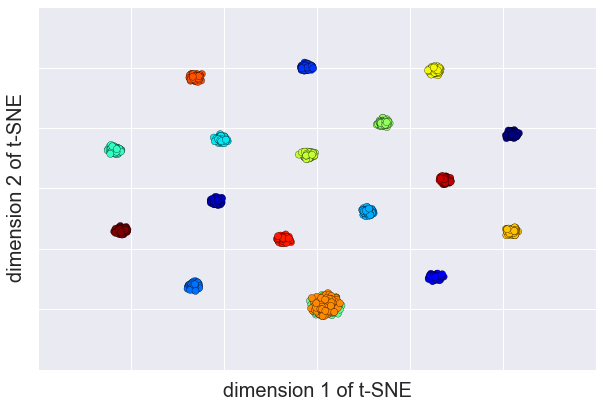

In [8]:
fig = plt.figure(figsize=(10, 6.5))
plt.scatter(Y[:, 0], Y[:, 1], c=label, cmap=plt.cm.jet, s=50, alpha=1)
ax = plt.gca();
ax.axes.get_xaxis().set_ticklabels([]);
ax.axes.get_yaxis().set_ticklabels([]);
plt.xlabel("dimension 1 of t-SNE", fontsize=20);
plt.ylabel("dimension 2 of t-SNE", fontsize=20);

In [9]:
from scipy.spatial.distance import pdist

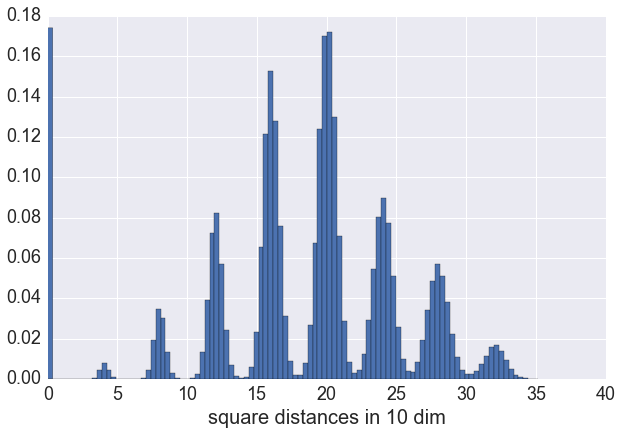

In [11]:
dst = pdist(lst, 'sqeuclidean')
fig = plt.figure(figsize=(10, 6.5));
plt.hist(dst, bins=100, normed=True);
plt.xlabel('square distances in {} dim'.format(dimensions), fontsize=20);

plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=14)

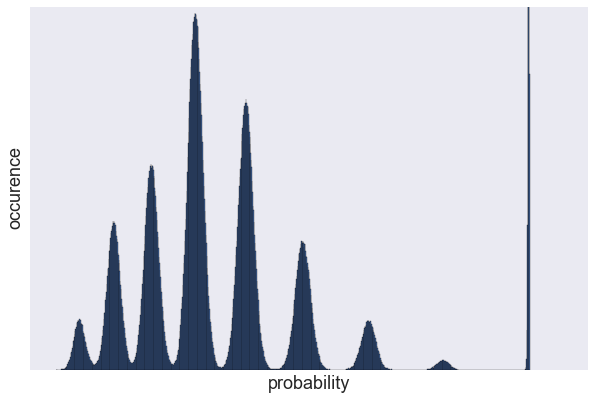

In [66]:
sigma = 30
prob_dist = np.exp(-1*dst/ sigma) / np.exp(-1*dst/ sigma).sum()

fig = plt.figure(figsize=(10, 6.5))
plt.hist(prob_dist, bins=1000);
plt.ylim([0, 12000]);
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('probability', fontsize=18)
plt.ylabel('occurence', fontsize=18)


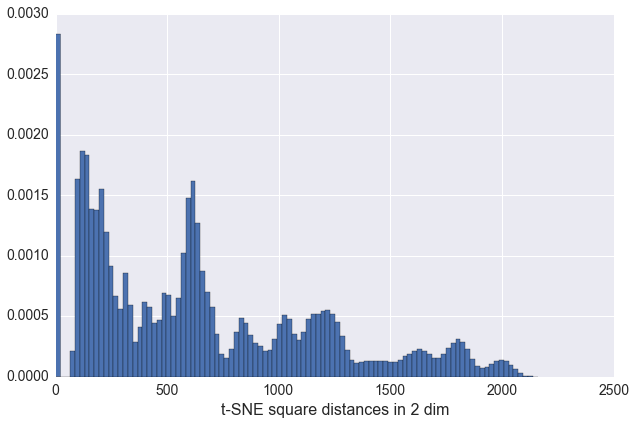

In [67]:
dst_2 = pdist(Y, 'sqeuclidean')
fig = plt.figure(figsize=(10, 6.5));
plt.hist(dst_2, bins=100, normed=True);

plt.xlabel('t-SNE square distances in 2 dim', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

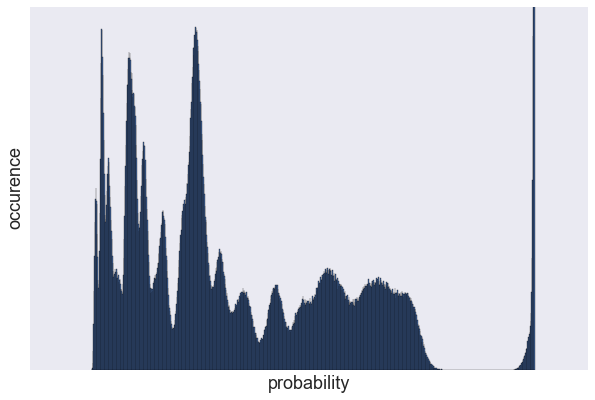

In [91]:
sigma = 300
prob_dist = np.power(1+ dst_2 / sigma, -1) / np.power(1+ dst_2 / sigma, -1).sum()

fig = plt.figure(figsize=(10, 6.5))
plt.hist(prob_dist, bins=1000);
plt.ylim([0, 7000]);
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('probability', fontsize=18)
plt.ylabel('occurence', fontsize=18)

# Average distance between uniformly distributed points in $d$ dimensions

In [92]:
import numpy.random as rd
from scipy.spatial.distance import pdist

mean_dist = []
for dim in range(1, 101):
    X = rd.uniform(low=-1.0, high=1.0, size=(1000, dim))
    mean_dist.append(pdist(X).mean())

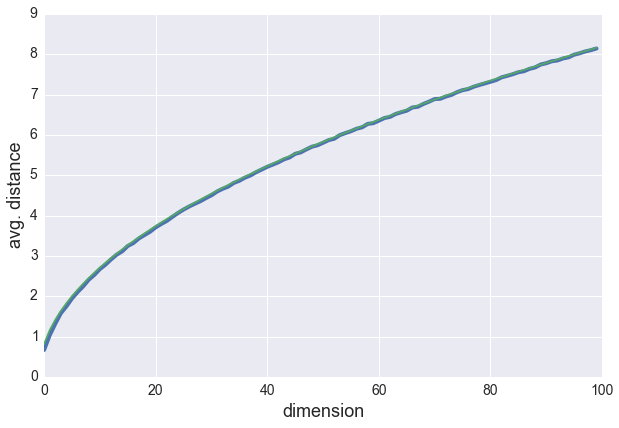

In [93]:
fig = plt.figure(figsize=(10,6.5));
plt.plot(mean_dist, linewidth=4);
d = np.arange(len(mean_dist))
y =np.sqrt( 0.6666 *  (d+1))
plt.plot(d, y);
plt.xlabel('dimension', fontsize=18);
plt.ylabel('avg. distance', fontsize=18);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);